# Phase Synchrony

In [1]:
import re
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from frites.conn import conn_spec
from frites.conn.conn_tf import _create_kernel
from IPython.display import clear_output
from mne_connectivity import spectral_connectivity_time
from neurodsp.rhythm import compute_lagged_coherence
from scipy.signal import fftconvolve, hilbert

# helper function

# create dataframe of phase synchrony data for classification task
def prepare_conn_df(conn_path,
                    behavioral_path,
                    origin: str,
                    tasks=[
                            'baseline1',
                            'baseline2',
                            'experience1',
                            'experience2',
                            'experience3',
                            'experience4'
                          ],
                    frequencies=['delta', 'theta', 'alpha', 'beta', 'gamma']):
  
  # create a datframe from the phase synchrony data
  # initiate an empty df
  conn_df_total = pd.DataFrame()

  # open data
  for subject_path in sorted(Path('data/connectivities/PLV/sensor').glob('*.nc')):
    
    search_exp = '(.*)_task-(.*)_conn-plv.*'
    if origin == 'sensor':
      search_exp = '(.*)_task-(.*)_conn-plv_sensor.*'
    
    subject, task = re.search(search_exp, subject_path.stem).groups()
      
    conns = xr.open_dataarray(subject_path)
    frequencies = frequencies
    
    # create a connectivity dataframe for one subject-task across 5 different frequency bins
    conn_df = pd.DataFrame()
    for i, freq in enumerate(frequencies):
      index = [conns['roi'].values.tolist()[n] + f' ({freq})' for n in range(len(conns['roi']))]
      conn_df_ = pd.DataFrame(conns[:, i],
                              index=index,
                              columns=[0]).T
      conn_df = conn_df.join(conn_df_, how='outer')

    conn_df_total = pd.concat([conn_df_total, conn_df], axis=0)

  subjects = [f'{i:02}' for i in range(1, 53)]
  tasks = tasks   
  # set index
  index = []
  [index.append(sub + '_' + cond) for sub in subjects for cond in tasks ]
  [index.remove(i) for i in ['52_experience2', '52_experience3']]

  conn_df_total = conn_df_total.set_axis(index)
  # open behavioral data and ids map
  bh = pd.read_csv('data/behavioral_data/archived/plb_hyp_data.csv', index_col='index')
  ids_map = pd.read_excel('docs/ids_map.xlsx', header=1, index_col='behavioral_id')
  ids_map = ids_map.drop_duplicates('bids_id')
  ids_map = ids_map[['bids_id']]
  ids_map['bids_id'] = ids_map['bids_id'].apply(lambda x:str(x).zfill(2))
  bh = bh.join(ids_map, how='right')
  bh = bh.melt(
      id_vars=['procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
              'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4'],
      value_vars=['hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4'])
  bh['session'] = bh['variable'].apply(lambda x:x.split('_')[2])
  bh['procedure'] = bh.apply(lambda r: r['procedure_type_'+r['session']], axis=1)
  bh['description'] = bh.apply(lambda r: r['description_type_'+r['session']], axis=1)
  bh = bh[['bids_id', 'value', 'procedure', 'description', 'session']].sort_values(by=['bids_id', 'session']).set_index('bids_id')
  bh = bh.rename(columns={'value':'hypnosis_depth'})
  bh.reset_index(inplace=True)

  # merge connectivity data with behavioral data
  conn_df_total[['bids_id', 'condition']] = conn_df_total.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
  conn_df_total['session'] = conn_df_total['condition'].apply(lambda x:x[-1])
  conn_df_total.reset_index(drop=True, inplace=True)
  conn_df_total = pd.merge(bh, conn_df_total, how='right', on=['session', 'bids_id'], right_index=False)
  conn_df_total = conn_df_total.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
  conn_df_total.insert(1, 'condition', conn_df_total.pop('condition'))
  
  return conn_df_total

### How does kernel smoothing affect PLV?

In [23]:
time_points = 100000

x = np.arange(0, time_points, 1)
# y1 = np.random.rand(time_points)
# y2 = np.random.rand(time_points)

y1 = np.sin(x)
y2 = np.cos(x)


kernel = _create_kernel(10000, 1, kernel='hanning')[0, :] # the length of the time smoothing is very important!

hill1 = hilbert(y1)
hill2 = hilbert(y2)

s_xy = hill1 * np.conj(hill2)
exp_dphi = s_xy / np.abs(s_xy)
plv2 = np.abs(np.mean(s_xy / np.abs(s_xy)))


exp_dphi = fftconvolve(exp_dphi, kernel) # comment this line to see the effect of the kernel smoothing
# Does it make any difference if we calculate the mean first and then get the length of the average vector?
plv1 = np.abs(exp_dphi).mean()
# synchrony = 1 - np.sin(np.abs(phase1 - phase2) / 2)


plv1, plv2

(0.9090707847923393, 0.9999687706612362)

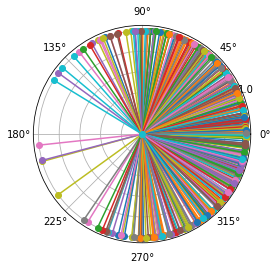

In [77]:
# Plot the normalized phase difference
for x in exp_dphi[:500]:
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')

## Phase Synchrony between Parcellated Source

In [3]:
# labels
yeo7 = {
    'N1': 'Visual',
    'N2': 'Somatomotor',
    'N3': 'DorsalAttention',
    'N4': 'VentralAttention',
    'N5': 'Limbic',
    'N6': 'Frontoparietal',
    'N7': 'Default',
    'mwall': 'Medial_Wall',
}

hemisferes = ['lh', 'rh']

# labels based on Yeo2011 atlas orders
network_labels = [yeo7[k]+'_'+ hemisferes[i] for k in yeo7.keys() for i in range(len(hemisferes))]

In [4]:
foi = np.array([
        [1, 4],
        [4, 8],
        [8, 13],
        [13, 30],
        [30, 42]
        ])

freqs = np.arange(1, 42, 1)

# open data
for subject_path in sorted(Path('data/parcellated_source_yeo7').glob('*.npz')):

    subject, task = re.search('(.*)_task-(.*)_labels.*', subject_path.stem).groups()
    label_ts = np.load(subject_path)['labels']
    
    output_path_plv = Path(f'data/connectivities/PLV/{subject}_task-{task}_conn-plv.nc')
    
    # create a continuous data array from the parcellated source data
    label_continious = np.array([np.hstack(np.array(label_ts))])
    
    conn = conn_spec(label_continious,
                     metric='plv',
                     freqs=freqs,
                     roi=network_labels,
                     sfreq=512,
                     foi=foi,
                     sm_times=10,
                     sm_freqs=1,
                     n_cycles=5,
                     n_jobs=1)

    # save dataarray
    conn = conn.mean('times').mean('trials')
    conn.to_netcdf(output_path_plv)
    
    clear_output()

In [7]:
# create a datframe from the phase synchrony data
# initiate an empty df
conn_df_total = pd.DataFrame()

# open data
for subject_path in sorted(Path('data/connectivities/PLV/').glob('*.nc')):
  
  subject, task = re.search('(.*)_task-(.*)_conn-plv.*', subject_path.stem).groups()
    
  conns = xr.open_dataarray(subject_path)
  frequencies = ['delta', 'theta', 'alpha', 'beta', 'gamma']
  
  # create a connectivity dataframe for one subject-task across 5 different frequency bins
  conn_df = pd.DataFrame()
  for i, freq in enumerate(frequencies):
    index = [conns['roi'].values.tolist()[n] + f' ({freq})' for n in range(len(conns['roi']))]
    conn_df_ = pd.DataFrame(conns[:, i],
                            index=index,
                            columns=[0]).T
    conn_df = conn_df.join(conn_df_, how='outer')

  conn_df_total = pd.concat([conn_df_total, conn_df], axis=0)

subjects = [f'{i:02}' for i in range(1, 53)]
tasks = [
'baseline2',
'experience1',
'experience2',
'experience3',
'experience4'
  ]    
# set index
index = []
[index.append(sub + '_' + cond) for sub in subjects for cond in tasks ]
[index.remove(i) for i in ['52_experience2', '52_experience3']]
conn_df_total = conn_df_total.set_axis(index)

# save dataframe
# conn_df_total.to_csv('data/classification_datasets/connectivities_yeo7nets_plv.csv')

In [8]:
# open behavioral data and ids map
bh = pd.read_csv('docs/plb_hyp_data.csv', index_col='index')
ids_map = pd.read_excel('docs/ids_map.xlsx', header=1, index_col='behavioral_id')
ids_map = ids_map.drop_duplicates('bids_id')
ids_map = ids_map[['bids_id']]
ids_map['bids_id'] = ids_map['bids_id'].apply(lambda x:str(x).zfill(2))
bh = bh.join(ids_map, how='right')
bh = bh.melt(
    id_vars=['procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
             'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4'],
    value_vars=['hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4'])
bh['session'] = bh['variable'].apply(lambda x:x.split('_')[2])
bh['procedure'] = bh.apply(lambda r: r['procedure_type_'+r['session']], axis=1)
bh['description'] = bh.apply(lambda r: r['description_type_'+r['session']], axis=1)
bh = bh[['bids_id', 'value', 'procedure', 'description', 'session']].sort_values(by=['bids_id', 'session']).set_index('bids_id')
bh = bh.rename(columns={'value':'hypnosis_depth'})
bh.reset_index(inplace=True)
bh.head()

,bids_id,hypnosis_depth,procedure,description,session
0,01,6.0,whitenoise,hypnosis,1
1,01,7.0,relaxation,control,2
2,01,8.0,confusion,hypnosis,3
3,01,1.0,embedded,control,4
4,02,1.0,relaxation,control,1


In [9]:
conn_df_total[['bids_id', 'condition']] = conn_df_total.index.to_series().apply(lambda x:x.split('_')).apply(pd.Series)
conn_df_total['session'] = conn_df_total['condition'].apply(lambda x:x[-1])
conn_df_total.reset_index(drop=True, inplace=True)
conn_df_total = pd.merge(bh, conn_df_total, how='right', on=['session', 'bids_id'], right_index=False)
conn_df_total = conn_df_total.sort_values(by=['bids_id', 'session', 'condition']).reset_index(drop=True)
conn_df_total.insert(1, 'condition', conn_df_total.pop('condition'))
conn_df_total.head()

,bids_id,condition,hypnosis_depth,procedure,description,session,Visual_lh-Visual_rh (delta),Somatomotor_lh-Visual_lh (delta),Somatomotor_rh-Visual_lh (delta),DorsalAttention_lh-Visual_lh (delta),...,Default_lh-Frontoparietal_rh (gamma),Default_rh-Frontoparietal_rh (gamma),Frontoparietal_rh-Medial_Wall_lh (gamma),Frontoparietal_rh-Medial_Wall_rh (gamma),Default_lh-Default_rh (gamma),Default_lh-Medial_Wall_lh (gamma),Default_lh-Medial_Wall_rh (gamma),Default_rh-Medial_Wall_lh (gamma),Default_rh-Medial_Wall_rh (gamma),Medial_Wall_lh-Medial_Wall_rh (gamma)
0,01,experience1,6.0,whitenoise,hypnosis,1,0.695081,0.404219,0.502637,0.566330,...,0.671595,0.125847,0.875941,0.894455,0.109182,0.651437,0.678821,0.304090,0.256728,0.979303
1,01,baseline2,7.0,relaxation,control,2,0.597270,0.529489,0.328948,0.545271,...,0.773920,0.561670,0.904934,0.915564,0.451839,0.771881,0.783238,0.714949,0.686408,0.984367
2,01,experience2,7.0,relaxation,control,2,0.509994,0.362237,0.364193,0.406488,...,0.791369,0.087189,0.856581,0.880916,0.094028,0.761149,0.783267,0.226877,0.182310,0.980835
3,01,experience3,8.0,confusion,hypnosis,3,0.624347,0.510232,0.343688,0.521527,...,0.690642,0.383398,0.871768,0.889827,0.253606,0.671123,0.686693,0.588235,0.551889,0.981213
4,01,experience4,1.0,embedded,control,4,0.609484,0.425330,0.359766,0.502865,...,0.765137,0.325834,0.883058,0.903144,0.203717,0.732514,0.754906,0.534298,0.495080,0.984900


## Phase Synchrony at Sensor Level

### Define a function for PLV calculation!

In [55]:
# constants for conn_spec function
foi = np.array([
        [1, 4],
        [4, 8],
        [8, 13],
        [13, 30],
        [30, 42]
        ])

freqs = np.arange(1, 42, 1)
sfreq = 512

# ROI names
file_path = sorted(Path('data/clean_data').glob('*.fif'))[10]
epochs = mne.read_epochs(file_path)
epochs.pick_types(eeg=True) # pick eeg channels
epochs.drop_channels(['M1', 'M2']) # drop mastoids
ch_names = epochs.ch_names # channel names

def calculate_ps(file_path,
                 metric='plv',
                 sfreq=sfreq,
                 freqs=freqs,
                 foi=foi,
                 roi=ch_names,
                 save=False,
                 output_dir='data/connectivities/PLV/sensor/',
                 file_name_postfix='_sensor'
                 ):
    
    # open eeg file and modify
    epochs = mne.read_epochs(file_path)
    
    # pick eeg channels based on roi
    epochs.pick_channels(roi)
        
    # do resampling if needed
    if sfreq <= 1000:
        epochs.resample(sfreq) # resample to speed-up
    
    # set montage
    montage = mne.channels.make_standard_montage('standard_1020')
    epochs.set_montage(montage)
    print(epochs.info)
      
    # surface laplacian
    epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
    
    # create a continuous data array and add a new dimention (for conn_spec function)
    data = np.array([np.hstack(epochs_csd.get_data())])
    
    # print subject/task
    subject, task = re.search('(.*)_ses-01_task-(.*)_proc-clean_epo.*', file_path.stem).groups()
    print(f'>>>>>>>> Processing {task} for {subject}...')
    
    conn = conn_spec(data,
                     metric=metric,
                     freqs=freqs,
                     roi=ch_names,
                     sfreq=sfreq,
                     foi=foi,
                     sm_times=10,
                     sm_freqs=1,
                     n_cycles=5,
                     n_jobs=1,
                     decim=10, # to speedup
                     verbose=0
                    )
    
    # aggregate
    conn = conn.mean('times').mean('trials')
    
    if save:
        # save dataarray
        output_file_name = f'{subject}_task-{task}_conn-plv{file_name_postfix}.nc'
        output_path = output_dir + output_file_name
        conn.to_netcdf(output_path)
    
    clear_output()
    
    return conn

### Examine the impact of the decimation on the value of the aggregated PLVs.

In [ ]:
# open decimated data and compare
path1 = Path(f'data/connectivities/PLV/sensor/tests/conn_512_d1.nc')
path2 = Path(f'data/connectivities/PLV/sensor/tests/conn_512_d5.nc')
path3 = Path(f'data/connectivities/PLV/sensor/tests/conn_512_d10.nc')
path4 = Path(f'data/connectivities/PLV/sensor/tests/conn_1000_d5.nc')
path5 = Path(f'data/connectivities/PLV/sensor/tests/conn_1000_d10.nc')

# 10 min
conn_512_d1 = xr.open_dataarray(path1).to_numpy()

# 1.11.1 min
conn_512_d5 = xr.open_dataarray(path2).to_numpy()

# 40.8s
conn_512_d10 = xr.open_dataarray(path3).to_numpy()

# 2:40 min
conn_1000_d5 = xr.open_dataarray(path4).to_numpy()

# 1:17 min
conn_1000_d10 = xr.open_dataarray(path5).to_numpy()

# 31.9s
conn_256_d5 = conn_256_d5.to_numpy()

### Make PLV claculation parallel!

In [4]:
from joblib import Parallel, delayed
from tqdm import tqdm
import time

start_time = time.perf_counter()

# file paths to all the clean eeg data segments except induction segments
file_paths = [i for i in sorted(Path('data/clean_data').glob('*.fif')) if 'induction' not in str(i)]

conn = Parallel(n_jobs=3)(
    delayed(calculate_ps)(file_path) for file_path in file_paths
)

finish = time.perf_counter()
print(f'Finished in {round(finish-start_time, 2)} seconds')

100%|██████████| Estimating pairwise Phase-Locking Value for trials 0...0 : 1596/1596 [00:49<00:00,   32.38it/s]
 79%|███████▉  | Estimating pairwise Phase-Locking Value for trials 0...0 : 1264/1596 [00:39<00:07,   45.93it/s]

100%|██████████| Estimating pairwise Phase-Locking Value for trials 0...0 : 1596/1596 [00:44<00:00,   35.72it/s]


Finished in 8670.59 seconds


### Prepare sensor-level phase synchrony dataset for classification.

In [61]:
# replace procedure, description and hypnosis_depth when condition is baseline
conn_df_total.loc[conn_df_total['condition'] == 'baseline1', ['procedure', 'description']] = 'baseline'
conn_df_total.loc[conn_df_total['condition'] == 'baseline2', ['procedure', 'description']] = 'baseline'
conn_df_total.loc[conn_df_total['condition'] == 'baseline1', ['hypnosis_depth']] = None
conn_df_total.loc[conn_df_total['condition'] == 'baseline2', ['hypnosis_depth']] = None

# save csv
# conn_df_total.to_csv('data/classification_datasets/plv_sensor.csv', index=0)

### ALPH2

In [64]:
# constants for alpha2 between F3-P3 and F4-P4
foi = np.array([
    [10.5, 12]
        ])
freqs = np.arange(10, 13, 0.5)
sfreq = 512

# ROI names
file_path = sorted(Path('data/clean_data').glob('*.fif'))[10]
ch_names = ['F3', 'F4', 'P4', 'P3']

file_paths = [i for i in sorted(Path('data/clean_data').glob('*.fif')) if 'induction' not in str(i)]

for file_path in file_paths:
    conn_alpha2 = calculate_ps(file_path,
                            metric='plv',
                            sfreq=512,
                            freqs=freqs,
                            foi=foi,
                            roi=ch_names,
                            save=True,
                            output_dir='data/connectivities/PLV/sensor/alpha2/',
                            file_name_postfix='_sensor_alpha2')